In [1]:
%load_ext autoreload
%autoreload 2

import os 

base_path = os.path.abspath(os.path.join(os.getcwd(), '../'))
os.chdir(base_path)


In [2]:
from src.utils import * 
import tensorflow as tf
import pandas as pd

2023-03-21 21:43:39.006812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model = tf.keras.models.load_model('models/siren')

2023-03-21 21:43:45.105316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load experimental slice 1 
c_q_slice1 = np.array(pd.read_csv(os.path.join('data_experimental/Qlist_path2_woBG.csv'), header=None)).T
c_E_slice1 = np.array(pd.read_csv(os.path.join('data_experimental/Elist_path2_woBG.csv'), header=None)[0]).T
c_sqw_slice1 = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path2.csv'), header=None)).T
c_sqw_slice1_woBG = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path2_woBG.csv'), header=None)).T

# Load experimental slice 2
c_q_slice2 = np.array(pd.read_csv(os.path.join('data_experimental/Qlist_path3_woBG.csv'), header=None)).T
c_E_slice2 = np.array(pd.read_csv(os.path.join('data_experimental/Elist_path3_woBG.csv'), header=None)[0]).T
c_sqw_slice2 = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path3.csv'), header=None)).T
c_sqw_slice2_woBG = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path3_woBG.csv'), header=None)).T


Let's visualize the experimental data (PATH 1 and PATH 2 on the left and right respectively). Note that the data in PATH 2 has a missing region (black).

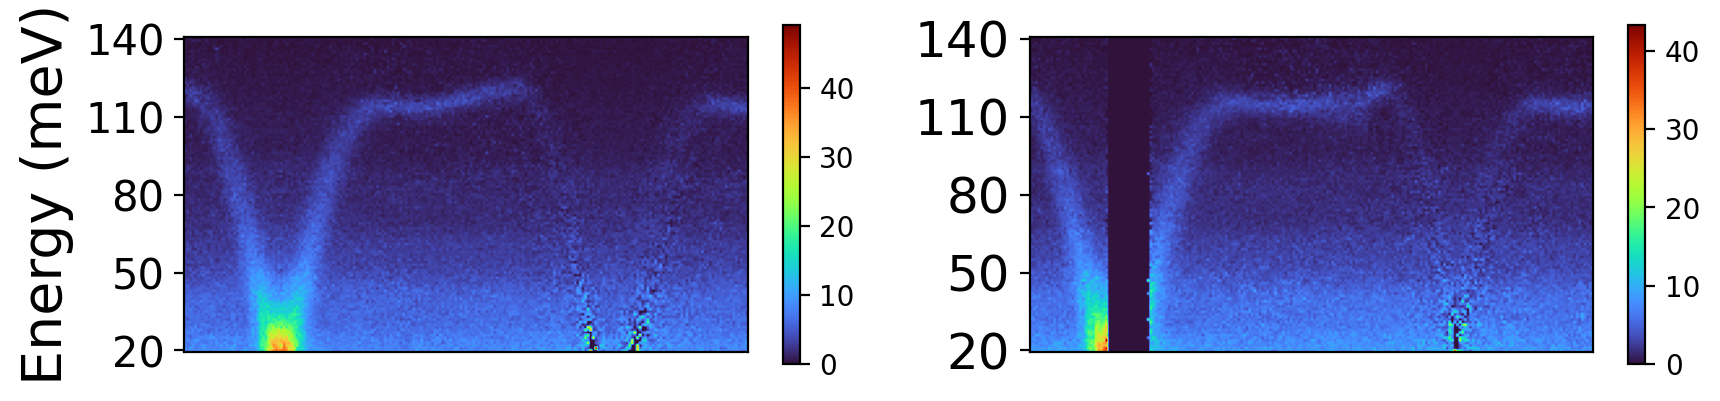

In [6]:
fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
im1 = axs[0].imshow(c_sqw_slice1.T, origin = 'lower', cmap = 'turbo', vmin=0)
cb1 = fig.colorbar(im1, ax=axs[0], shrink = 0.22)

im2 = axs[1].imshow(c_sqw_slice2.T, origin = 'lower', cmap = 'turbo', vmin=0)
cb2 = fig.colorbar(im2, ax=axs[1], shrink = 0.22)

axs[0].set_ylabel('Energy (meV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 18)

axs[0].set_xticks([])
axs[1].set_xticks([])

plt.show()


Here, we also show the data after background subtraction:

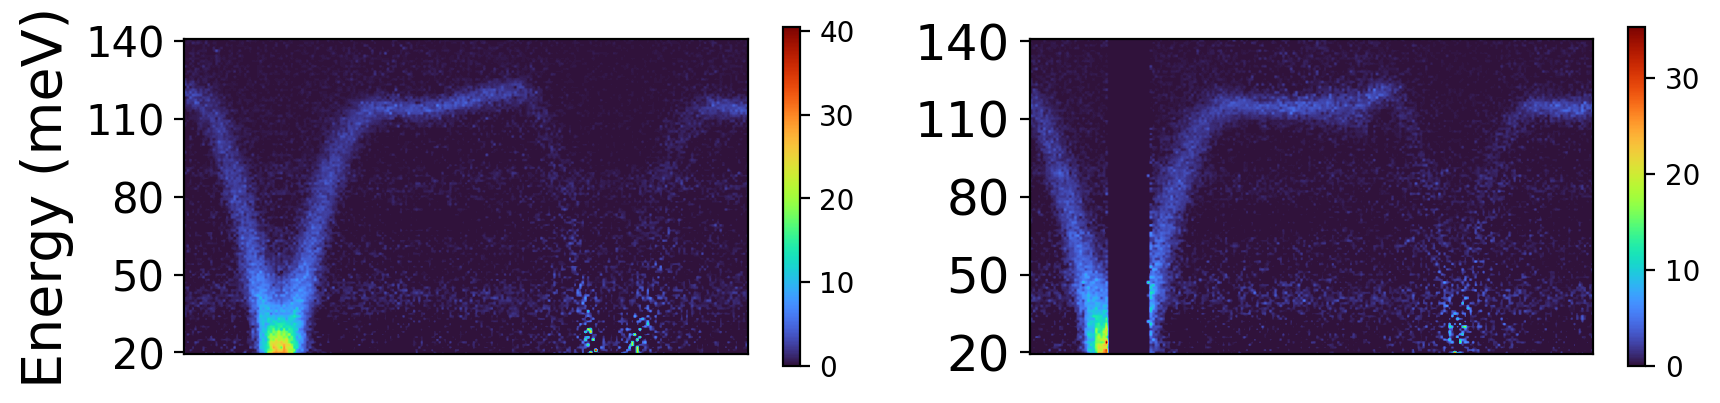

In [27]:
fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
im1 = axs[0].imshow(c_sqw_slice1_woBG.T, origin = 'lower', cmap = 'turbo', vmin=0)
cb1 = fig.colorbar(im1, ax=axs[0], shrink = 0.22)

im2 = axs[1].imshow(c_sqw_slice2_woBG.T, origin = 'lower', cmap = 'turbo', vmin=0)
cb2 = fig.colorbar(im2, ax=axs[1], shrink = 0.22)

axs[0].set_ylabel('Energy (meV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 18)

axs[0].set_xticks([])
axs[1].set_xticks([])

plt.show()


In [7]:
# Convert image data into (q, E) format for tensorflow optimization
test_x_1, test_y_1 = image_to_coords(c_q_slice1, c_E_slice1, c_sqw_slice1, background_start=160,background_end=170)
test_x_2, test_y_2 = image_to_coords(c_q_slice2, c_E_slice2, c_sqw_slice2, background_start=160,background_end=170)

# Fit slice 1 

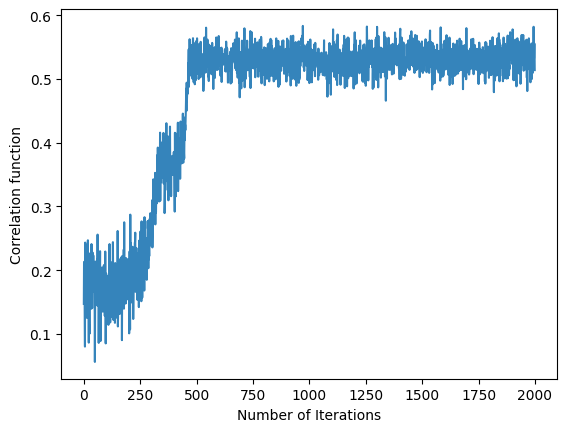

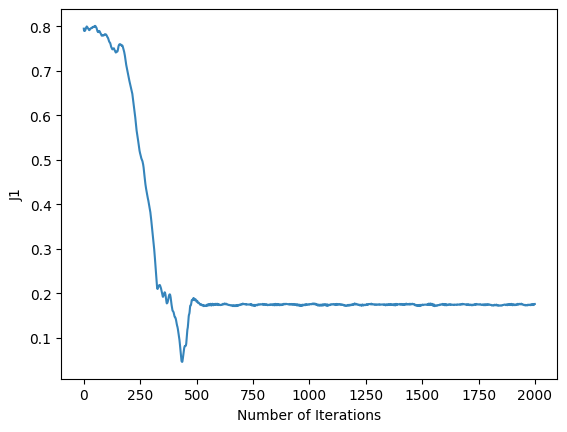

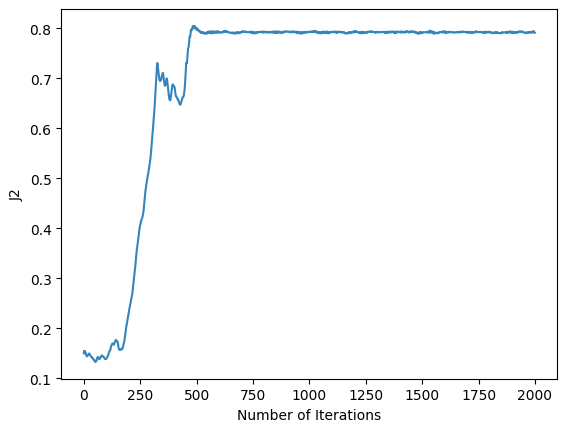

In [8]:
test_x = tf.convert_to_tensor(test_x_1, dtype=tf.float32)
test_y = tf.convert_to_tensor(test_y_1, dtype=tf.float32)

# Run surrogate model optimization
learning_rate = 0.005 
batch_size = 4096
max_iter=2000

min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, test_y, model, learning_rate = learning_rate, batch_size = batch_size, max_iter=max_iter, plotting = True, fixed_start = True, set_seed = True)

The optimized parameters are returned in normalized units. In the following cell we unnormalize them to be in meV. 

In [170]:
unnormalize_j1_j2(min_loss_j1, min_loss_j2)

(29.56867776811123, 1.6001462936401367)

Let's visually inspect our solution by running our predicted exchange parameters through the surrogate neural model. By eye, it is very similar to the experimental data. 

821/821 [==============================] - 1s 1ms/step


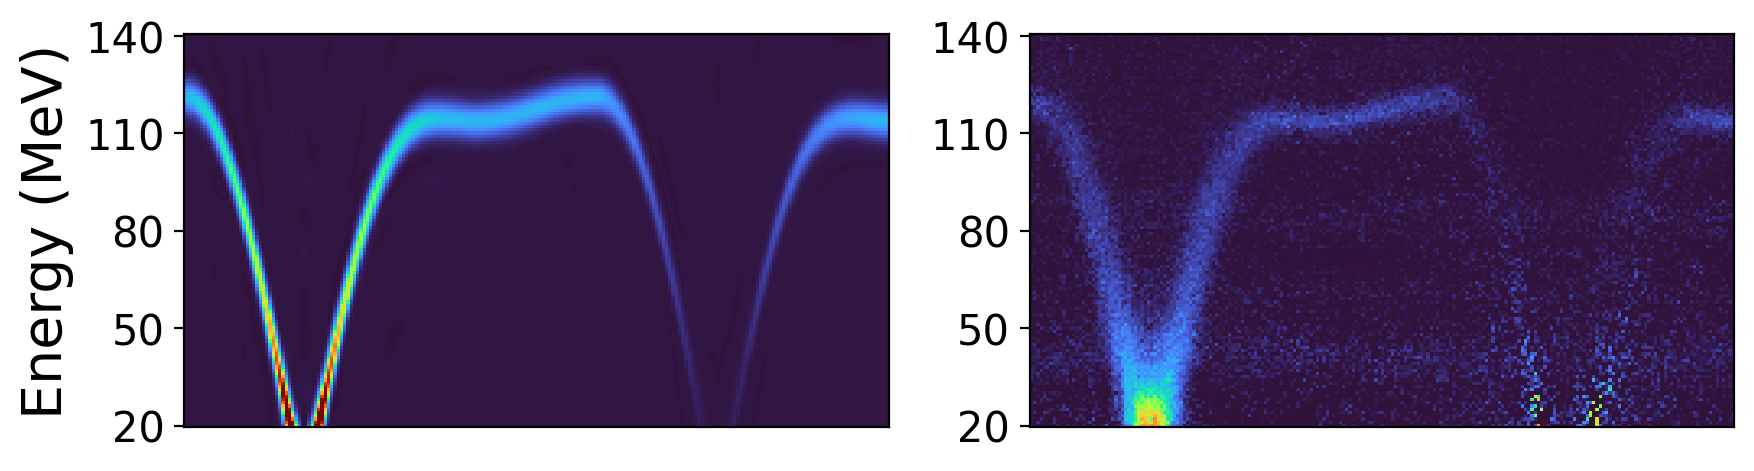

In [26]:
model_prediction_slice1 = path2mesh_expt(min_loss_j1, min_loss_j2, c_q_slice1, c_E_slice1, model)
fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
axs[0].imshow(np.exp(model_prediction_slice1)-1, origin = 'lower', cmap = 'turbo', vmax=0.5)
axs[1].imshow(c_sqw_slice1_woBG.T, origin = 'lower', cmap = 'turbo', vmin=0)
axs[0].set_ylabel('Energy (MeV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[0].set_xticks([])
axs[1].set_xticks([])
plt.show()

# Fit slice 2

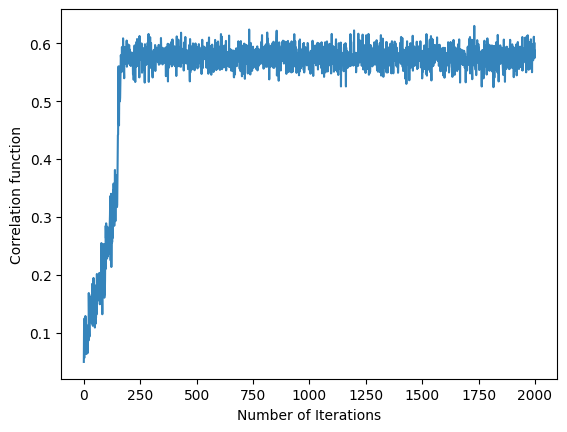

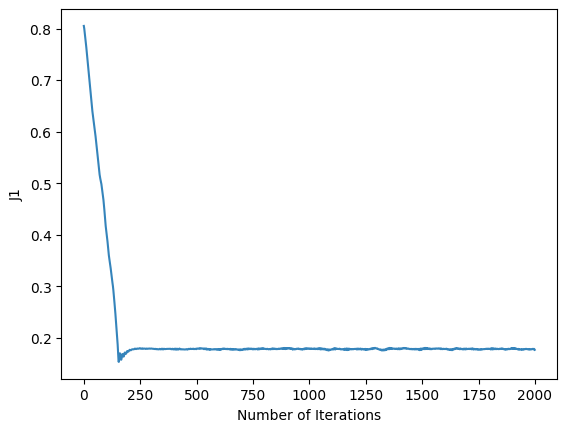

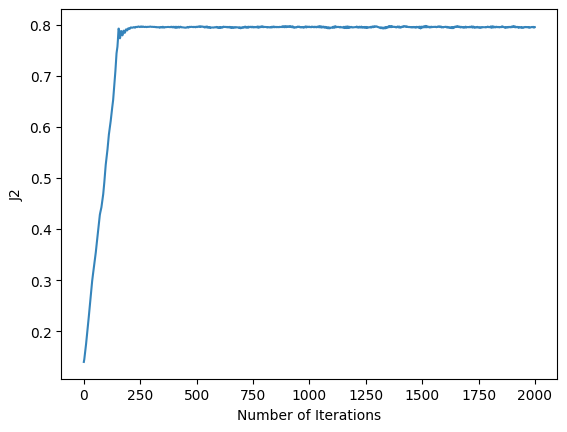

In [201]:
test_y = tf.convert_to_tensor(test_y_2[test_y_2 != 0], dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x_2[test_y_2 != 0], dtype=tf.float32)

# Run surrogate model optimization

learning_rate = 0.005
batch_size = 4096
max_iter=2000

min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, test_y, model, learning_rate = learning_rate, batch_size = batch_size, max_iter=max_iter, plotting = True, fixed_start = True, set_seed = True)

In [203]:
print(unnormalize_j1_j2(min_loss_j1, min_loss_j2))

(29.81896683573723, 1.7707419395446777)


Let's do the same for data fitted only on path 2.. 

821/821 [==============================] - 1s 1ms/step


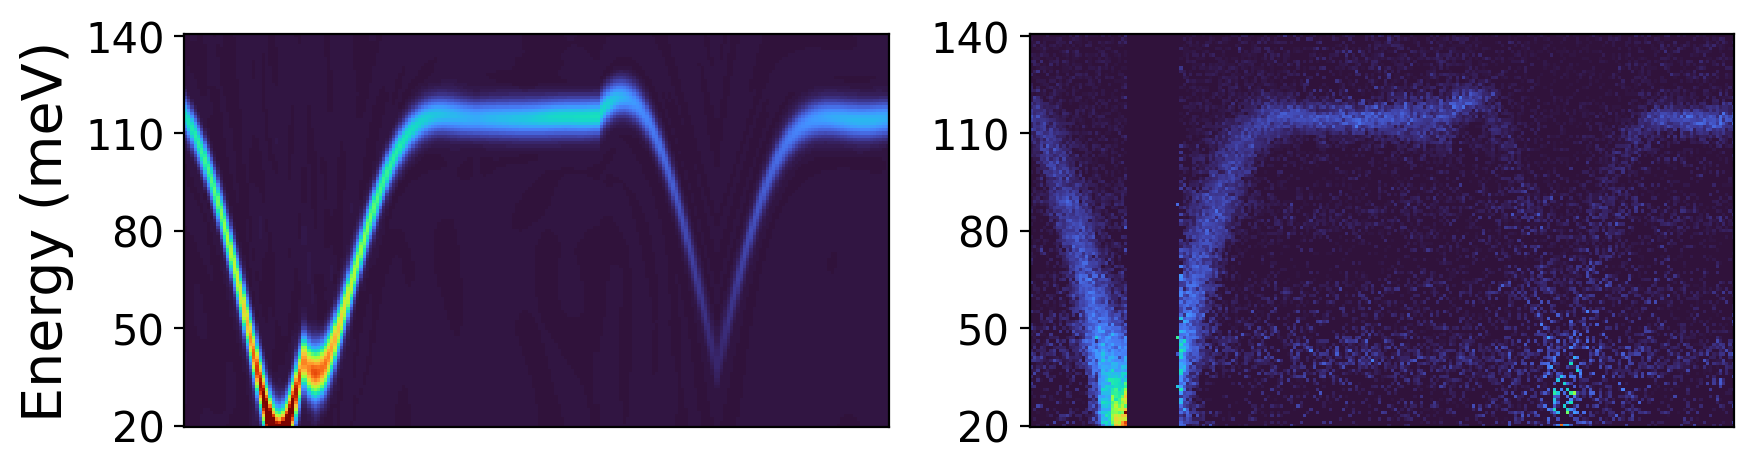

In [28]:
model_prediction_slice2 = path2mesh_expt(min_loss_j1, min_loss_j2, c_q_slice2, c_E_slice2, model)
fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
axs[0].imshow(np.exp(model_prediction_slice2)-1, origin = 'lower', cmap = 'turbo', vmax=0.5)
axs[1].imshow(c_sqw_slice2_woBG.T, origin = 'lower', cmap = 'turbo', vmin=0)
axs[0].set_ylabel('Energy (meV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[0].set_xticks([])
axs[1].set_xticks([])

plt.show()

# Fit slice 1 and 2 together 

In [18]:
# Convert image data into (q, E) format for tensorflow optimization
test_x_1, test_y_1 = image_to_coords(c_q_slice1, c_E_slice1, c_sqw_slice1, background_start=160,background_end=170)
test_x_2, test_y_2 = image_to_coords(c_q_slice2, c_E_slice2, c_sqw_slice2, background_start=160,background_end=170)

test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)

# mask applied to y on second slice because data is missing 
test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)

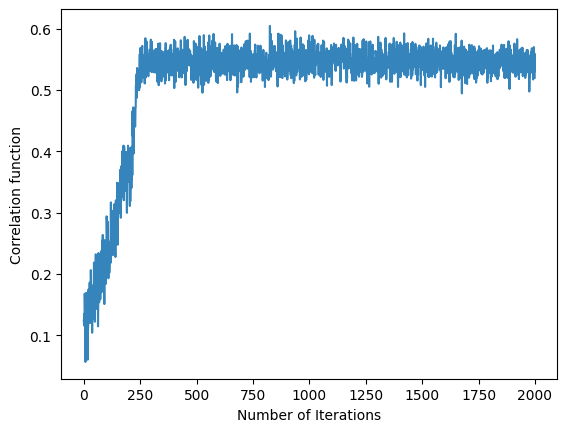

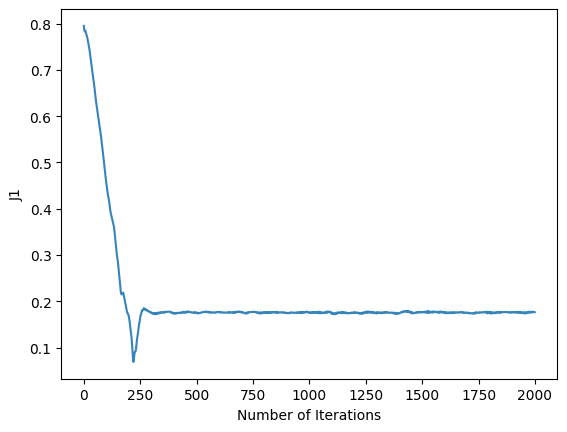

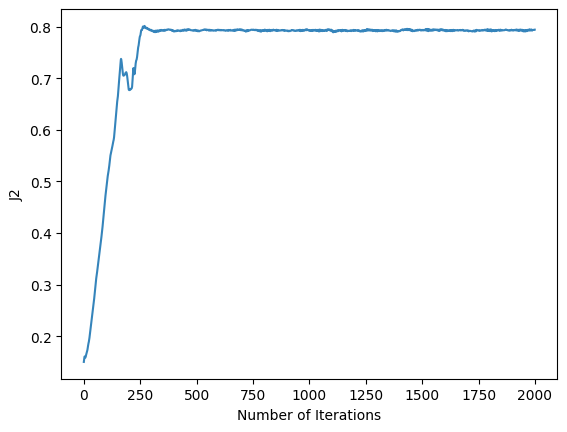

In [191]:
# Run surrogate model optimization

learning_rate = 0.005 
batch_size = 4096
max_iter=2000

min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, test_y, model, learning_rate = learning_rate, batch_size = batch_size, max_iter=max_iter, plotting = True, fixed_start = True, set_seed = True)

In [195]:
unnormalize_j1_j2(min_loss_j1, min_loss_j2)

(29.675625935196877, 1.7004179954528809)

In [30]:
model_prediction_slice2_both = path2mesh_expt(min_loss_j1, min_loss_j2, c_q_slice2, c_E_slice2, model)
np.save('figures/data_for_figures/prediction_array_fit_together_path2', model_prediction_slice2_both)

model_prediction_slice1_both = path2mesh_expt(min_loss_j1, min_loss_j2, c_q_slice1, c_E_slice1, model)
np.save('figures/data_for_figures/prediction_array_fit_together_path1', model_prediction_slice1_both)

821/821 [==============================] - 1s 1ms/step
0.17592047154903412 0.792510449886322


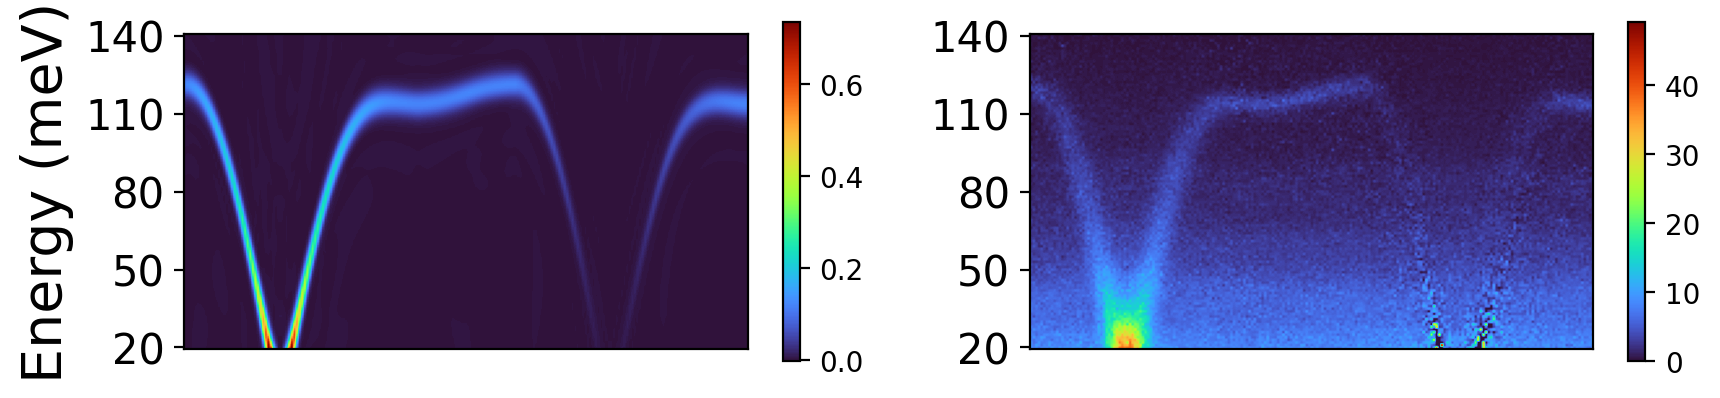

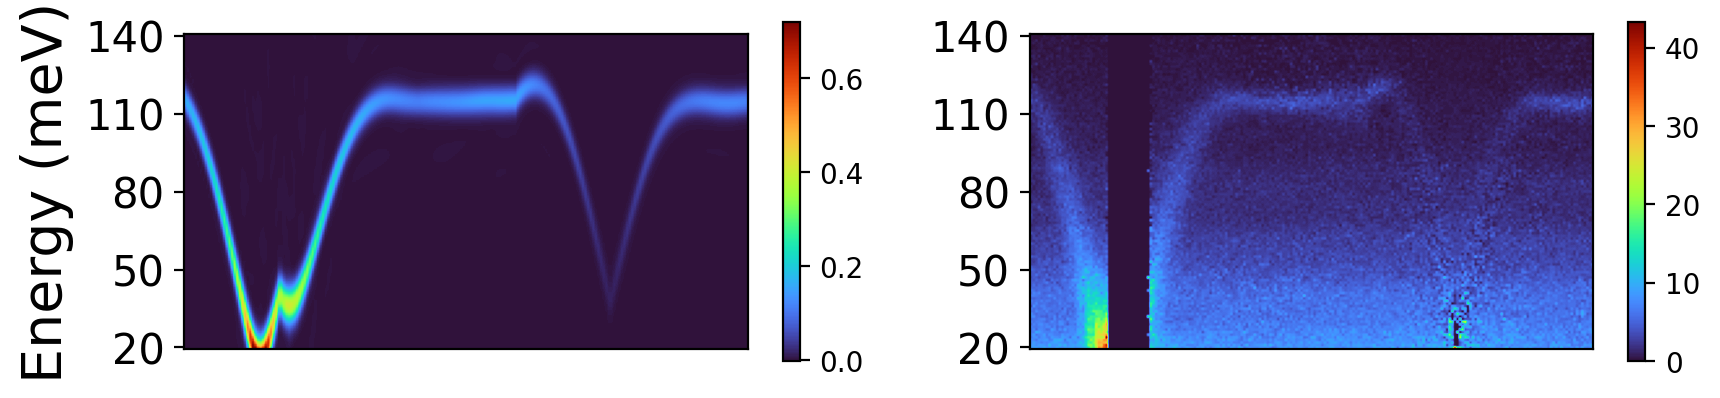

In [32]:
fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
im1 = axs[0].imshow(np.exp(model_prediction_slice1_both) - 1, origin = 'lower', cmap = 'turbo')
cb1 = fig.colorbar(im1, ax=axs[0], shrink = 0.22)
im2 = axs[1].imshow(c_sqw_slice1.T, origin = 'lower', cmap = 'turbo', vmin=0)
cb2 = fig.colorbar(im2, ax=axs[1], shrink = 0.22)

axs[0].set_ylabel('Energy (meV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[0].set_xticks([])
axs[1].set_xticks([])
plt.show()

fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(10,10))
im1 = axs[0].imshow(np.exp(model_prediction_slice2_both) - 1, origin = 'lower', cmap = 'turbo')
im2 = axs[1].imshow(c_sqw_slice2.T, origin = 'lower', cmap = 'turbo' , vmin=0)
fig.colorbar(im1, ax=axs[0], shrink = 0.22)
fig.colorbar(im2, ax=axs[1], shrink = 0.22)

axs[0].set_ylabel('Energy (meV)', fontsize= 20)
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 15)
axs[0].set_xticks([])
axs[1].set_xticks([])

plt.show()

## Missing Region

In this section, we compare the prediction of the ML model in the missing region of PATH 2 to an interpolation in Q space of the data (see manuscript SI).

In [35]:
# Load experimental slice 2
c_sqw_slice2_interpolated = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path3_woBG_corr.csv'), header=None)).T
c_sqw_slice2_interpolated = np.array(pd.read_csv(os.path.join('data_experimental/Sqw_path3_woBG_corr.csv'), header=None)).T


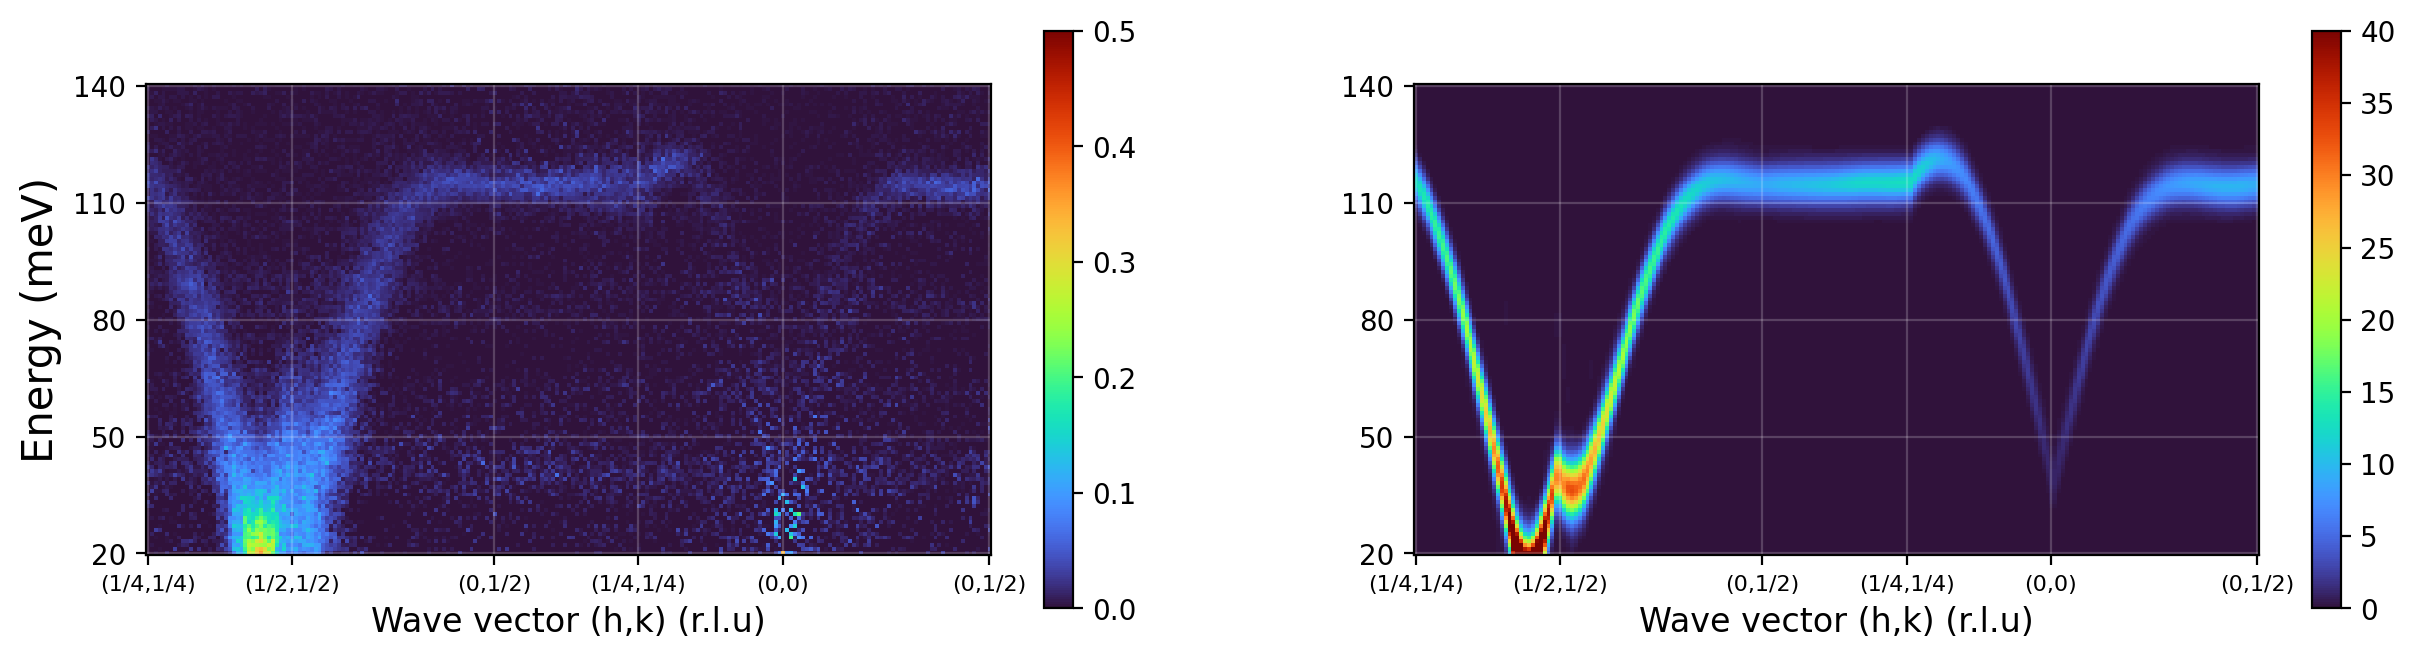

In [36]:
locations_of_x_gridlines = np.array([0, 37.0621, 89.4722, 126.5278, 163.5900, 216.0000], dtype=np.int16)

fig, axs = plt.subplots(1, 2, dpi = 200, figsize=(15,15))
im1 = axs[1].imshow(np.exp(model_prediction_slice2)-1, origin = 'lower', cmap = 'turbo', vmin=0, vmax=0.5)
im2 = axs[0].imshow(c_sqw_slice2_interpolated.T, origin = 'lower', cmap = 'turbo', vmin=0, vmax=40)
axs[0].set_ylabel('Energy (meV)', fontsize= 15)
axs[1].grid(which='major', axis='both', linestyle='-', color='white',alpha=0.2)  
axs[0].grid(which='major', axis='both', linestyle='-', color='white',alpha=0.2)  

axs[1].set_yticks(np.linspace(0,120,5))
axs[0].set_yticks(np.linspace(0,120,5))
axs[1].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 10)
axs[0].set_yticklabels(list(np.linspace(20,140,5).astype(int)), fontsize = 10)

axs[1].set_xticks([])
axs[0].set_xticks([])

cb1 = fig.colorbar(im1, ax=axs[0], shrink = 0.25)
cb2 = fig.colorbar(im2, ax=axs[1], shrink = 0.25)

axs[1].set_xticks(list(locations_of_x_gridlines), ['(1/4,1/4)', '(1/2,1/2)', '(0,1/2)', '(1/4,1/4)', '(0,0)', '(0,1/2)'], fontsize=8)
axs[0].set_xticks(list(locations_of_x_gridlines), ['(1/4,1/4)', '(1/2,1/2)', '(0,1/2)', '(1/4,1/4)', '(0,0)', '(0,1/2)'], fontsize=8)

axs[0].set_xlabel('Wave vector (h,k) (r.l.u)', fontsize= 12)
axs[1].set_xlabel('Wave vector (h,k) (r.l.u)', fontsize= 12)

#plt.savefig('figures/data_for_figures/missing.pdf', format='pdf')

plt.show()

# loss landscape

Calculate loss landscape for ML fitting procedure by evaluating the correlation loss over a large grid of points. 

In [ ]:
grid_size = 70 

# Convert image data into (q, E) format for tensorflow optimization
test_x_1, test_y_1 = image_to_coords(c_q_slice1, c_E_slice1, c_sqw_slice1, background_start=160,background_end=170)
test_x_2, test_y_2 = image_to_coords(c_q_slice2, c_E_slice2, c_sqw_slice2, background_start=160,background_end=170)

test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)

# mask applied to y on second slice because data is missing 
test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)

# if this is too slow, reduce grid resolution
loss_vals = calculate_loss_landscape(test_x, test_y, model, gridsize = grid_size)

loss_vals[:,0:2] = np.transpose(unnormalize_j1_j2(loss_vals[:,0], loss_vals[:,1]))
#np.save('figures/data_for_figures/loss_landscape_full', np.array(loss_vals))

In [37]:
loss_vals = np.load('figures/data_for_figures/loss_landscape_full.npy')

In [41]:
def map_range(value, from_low, from_high, to_low, to_high):
    from_range = from_high - from_low
    to_range = to_high - to_low
    scaled_value = float(value - from_low) / float(from_range)
    return to_low + (scaled_value * to_range)

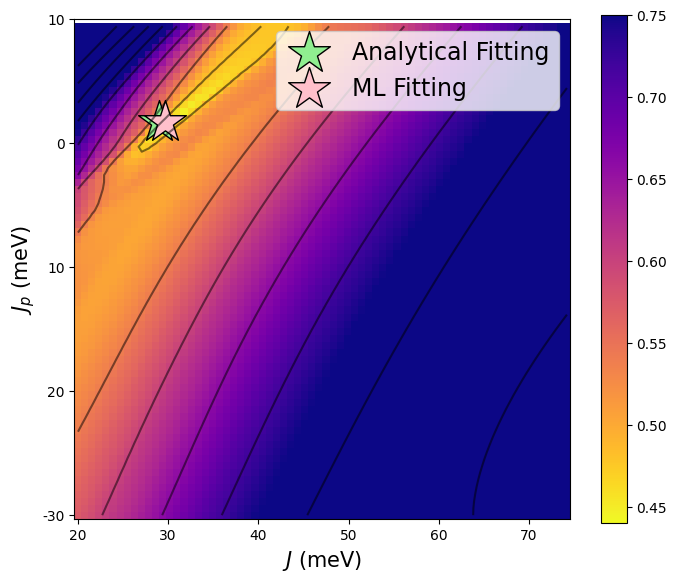

In [50]:
j_analytical_converted = map_range(29.00, 20, 75, 0, grid_size)
jp_analytical_converted = map_range(1.67, -30, 10, 0, grid_size)

j_ml_converted = map_range(29.68,  20, 75, 0, grid_size)
jp_ml_converted = map_range(1.70, -30, 10, 0, grid_size)

plt.figure(figsize=(8, 11), dpi=100)
plt.imshow(loss_vals[:,2].reshape(grid_size, grid_size), cmap='plasma_r', origin='lower', vmin=0.44, vmax=0.75)
plt.colorbar(shrink=0.6)

plt.contour(loss_vals[:,2].reshape(grid_size, grid_size), levels=10, colors='black', alpha=0.5)

# These numbers are the results of the ML and Analytical fit converted into 0-grid_size pixel units for plotting using imshow
plt.scatter([j_analytical_converted], [jp_analytical_converted], marker = '*', s=1000, edgecolor = 'black', color='lightgreen', label = 'Analytical Fitting')
plt.scatter([j_ml_converted], [jp_ml_converted], marker = '*', s=1000, edgecolor = 'black', color = 'pink', label = 'ML Fitting')

plt.xticks([map_range(i, 20, 75, 0, grid_size) for i in [20, 30, 40, 50, 60, 70]], [20, 30, 40, 50, 60, 70])
plt.yticks([map_range(i, -30, 10, 0, grid_size) for i in [-30, -20, -10, 0, 10]], [-30, 20, 10, 0, 10])
plt.legend(fontsize=17)

plt.xlabel('$J$ (meV)', fontsize=15)
plt.ylabel('$J_p$ (meV)', fontsize=15)
#plt.savefig('figures/figures_as_eps/loss_landscape.pdf')
plt.show()
